# Titration Experiment

In [1]:
#############################
#   Experiment parameters   #
#############################
ROOT_DIR = '/analysis/gh-msun/'
PROJECT_SLUG = '2023_06_26_SRT_deconvolution_MS'
EXPERIMENT = 't_subset_blueprint_5m'
TITRATING_CELLTYPE = 't_reg'
TITRATING_CELLTYPE_ATLAS = 'immune_treg' # cell type name in atlas different
BACKGROUND = 'wholeblood' # background: uniform / wholeblood 
N_REPLICATES = 20 # number of replicates for each mixture
SEED = 888 # need to change for different experiment
TOTAL_READS_TO_SAMPLE = 5000000

# make sure the orders of the two list match
CELLTYPES = ['t_reg',
             't_effector', 
             't_naive',
             'Blueprint-B',
             'Blueprint-NK',
             'Blueprint-Mono',
             'Blueprint-Neutro']
ABRIDGED_NAMES = ['Treg', 'Teff', 'Tnaive', 'B', 'NK', 'MONO', 'NEUTRO'] # for directory name

# TITRATION_LIST = [0.10, 0.08, 0.06, 0.04, 0.02, 0.01, 
#                   0.008, 0.006, 0.004, 0.002, 0.001, 0]


# # proportion of cells in real whole blood (sum to 1)
# WHOLE_BLOOD_ABUNDANCE = {'Blueprint-B':0.06,
#                          'Blueprint-Mono':0.09,
#                          'Blueprint-Neutro':0.57,
#                          't_naive':0.16+0.07,
#                          'Blueprint-NK':0.05}
    

In [2]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import functools
import os
import regex as re
import random
import importlib
import sys

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import IntegerType, LongType, ArrayType, StringType, DoubleType
from pyspark.sql.functions import udf, explode, broadcast, count, lit, length, col
from pyspark.sql import DataFrame
from pyspark.sql.types import StructType

# UPDATE HOME!
os.environ["SPARK_HOME"] = "/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/site-packages/pyspark"
# THIS needs to be set-up before running the notebook
os.environ["SPARK_LOCAL_DIRS"] = "/temp"
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

spark_conf = SparkConf()
spark_conf.set("spark.ui.showConsoleProgress", "True")
spark_conf.set("spark.executor.instances", "2")
spark_conf.set("spark.executor.cores", "2")
spark_conf.set("spark.executor.memory", "16g")
spark_conf.set("spark.driver.memory", "64g")
spark_conf.set("spark.driver.maxResultSize", "32g")
spark_conf.set("spark.parquet.filterPushdown", "true")
spark_conf.set("spark.local.dir", "/temp")
spark_conf.getAll()

sc = SparkContext(conf=spark_conf)
sc.setLogLevel("ERROR")
spark = SparkSession(sc)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
sns.set_context('talk')

/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [3]:
#---Local paths---#
PROJECT_DIR = ROOT_DIR + f'projects/{PROJECT_SLUG}/'

#---Load all custom scripts---#
SCRIPT_DIR = PROJECT_DIR + 'scripts/'
sys.path.append(SCRIPT_DIR)

import create_mixture as cm
import score_matrix as sm
import deconvolution as dcnv
import helper as hlpr

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
importlib.reload(cm)
importlib.reload(sm)
importlib.reload(dcnv)
importlib.reload(hlpr)

<module 'helper' from '/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/scripts/helper.py'>

In [5]:
CELLTYPES = ['t_reg',
             't_effector', 
             't_naive',
             'Blueprint-B',
             'Blueprint-NK',
             'Blueprint-Mono',
             'Blueprint-Neutro']

ABRIDGED_NAMES = ['Treg', 'Teff', 'Tnaive', 'B', 'NK', 'MONO', 'NEUTRO'] # for directory name

TITRATION_LIST = [0.20, 0.15, 0.10, 0.08, 0.06, 0.04, 0.02, 0.01, 
                  0.008, 0.006, 0.004, 0.002, 0.001, 0] # % of total T-cells

# background cell type proportion (T is around 20%)
WHOLE_BLOOD_ABUNDANCE = {'B':0.06,
                         'Mono':0.09,
                         'Neutro':0.57,
                         'NK':0.05}

# background: % of total T-cells (multipy with 0.2)
WHOLE_BLOOD_ABUNDANCE_T = {'t_effector':0.20,
                           't_naive':0.80}

PROPORTIONS = []
treg_titrating_proprotions = [] 
teff_titrating_proprotions = []
tnai_titrating_proprotions = []

for t, alpha in enumerate(TITRATION_LIST):  
    
    # T cell total to be 23 % 
    proportion_treg = 0.23 * alpha  # alpha is the titrating proportion
    proportion_teff = 0.23 * (1-alpha) * WHOLE_BLOOD_ABUNDANCE_T['t_effector'] 
    proportion_tnai = 0.23 * (1-alpha) * WHOLE_BLOOD_ABUNDANCE_T['t_naive'] 
    
    treg_titrating_proprotions.append(proportion_treg)
    teff_titrating_proprotions.append(proportion_teff)
    tnai_titrating_proprotions.append(proportion_tnai)
    
    proportion = [proportion_treg, 
                  proportion_teff, 
                  proportion_tnai,
                  WHOLE_BLOOD_ABUNDANCE['B'],
                  WHOLE_BLOOD_ABUNDANCE['NK'],
                  WHOLE_BLOOD_ABUNDANCE['Mono'],
                  WHOLE_BLOOD_ABUNDANCE['Neutro']]
    
    PROPORTIONS.append(proportion)


In [6]:
teff_titrating_proprotions

[0.036800000000000006,
 0.0391,
 0.041400000000000006,
 0.04232,
 0.04324,
 0.044160000000000005,
 0.04508000000000001,
 0.045540000000000004,
 0.045632000000000006,
 0.04572400000000001,
 0.045816,
 0.045908000000000004,
 0.045954,
 0.046000000000000006]

In [7]:
sum(PROPORTIONS[5][0:3])

0.23000000000000004

## Create mixture

In [8]:
############################
#   Parameters and paths   # 
############################
EXPERIMENT_DIR = PROJECT_DIR + f'output/experiment/{EXPERIMENT}/'
EXPERIMENT_NAME = f'{TITRATING_CELLTYPE}-{BACKGROUND}/'
PARQUET_PATH = PROJECT_DIR + 'output/mixture_source/t_subset_mixture_source/'
EXPERIMENT_CELLTYPE_DIR = EXPERIMENT_DIR + f'{EXPERIMENT_NAME}/'
RESULT_PATH = EXPERIMENT_CELLTYPE_DIR + 'mixture/'


In [9]:
%%time
# load parquet files for each celltype & count rows
parquet_df, total_reads_per_celltype = cm.load_parquet_dataframe(parquet_path=PARQUET_PATH,
                                                                  cell_types=CELLTYPES,
                                                                  spark=spark,
                                                                  verbose=True)

# mix cell types for each proportion set
cm.mix_celltypes_multiple_proportions(parquet_df=parquet_df,
                                       total_reads_per_celltype=total_reads_per_celltype,
                                    #    n=len(TITRATION_LIST), 
                                       n=N_REPLICATES,
                                       cell_types=CELLTYPES, 
                                       cell_type_abridged_name=ABRIDGED_NAMES, 
                                       total_reads_to_sample=TOTAL_READS_TO_SAMPLE, 
                                       list_of_proportions=PROPORTIONS, 
                                       seed=SEED, 
                                       result_path=RESULT_PATH, 
                                       spark=spark,
                                       verbose=False, 
                                       save=True)

>>> Load parquet files and count rows... <<<
----------> Loading cell type: t_reg
----------> Loading cell type: t_effector
----------> Loading cell type: t_naive
----------> Loading cell type: Blueprint-B
----------> Loading cell type: Blueprint-NK
----------> Loading cell type: Blueprint-Mono
----------> Loading cell type: Blueprint-Neutro
>>> Complete. <<< 

>>> Start mixing... <<<
--> PROPORTION: [0.046000000000000006, 0.036800000000000006, 0.14720000000000003, 0.06, 0.05, 0.09, 0.57]
----------> Creating mixture 0... 
----------> Creating mixture 1... 
----------> Creating mixture 2... 
----------> Creating mixture 3... 
----------> Creating mixture 4... 
----------> Creating mixture 5... 
----------> Creating mixture 6... 
----------> Creating mixture 7... 
----------> Creating mixture 8... 
----------> Creating mixture 9... 
----------> Creating mixture 10... 
----------> Creating mixture 11... 
----------> Creating mixture 12... 
----------> Creating mixture 13... 
----------> 

## Compute score matrix

In [10]:
############################
#   Parameters and paths   # 
############################

FILTER_CG_COUNT = 3
FILTER_CG_COUNT_REGION = 1

REGIONS = 'deconvolution_v2.v23_conv.with_cpg_index'
REGION_BED_COLS = [
    'region_chr', 'region_start', 'region_end', 
    'region_cpg_index_min', 'region_cpg_index_max', 'region_id'
]

# Regions
REGION_PATH = (
    PROJECT_DIR + '/stage/panel_data/{regions}.bed'
).format(regions=REGIONS)

# CpG map; genomic coordinate to CpG index;
CPG_MAP_PATH = PROJECT_DIR + '/stage/cpg_loci/cpg_loci_hg19.combined_annot.tsv.gz'

#--- Where to store results
PATH_TO_MIXTURE_DIR = EXPERIMENT_CELLTYPE_DIR + 'mixture/'
RESULT_PATH = EXPERIMENT_CELLTYPE_DIR


In [11]:
%%time

PAT_COLS = [
    'molecule_id', 'chr', 'number_molecules',
    'cpg_index_min', 'cpg_index_max', 'pat_string', 'region_id', 'region_cpg_index_min', 'region_cpg_index_max'
]

QUANTILES = [0.1, 0.25, 0.75, 0.9]
KMERS = [1, 3, 4]
RATES_LEQ = [0.25]
RATES_GEQ = [0.75]

RETURN_SCHEMA = StructType()\
    .add('region_id', 'string')\
    .add('number_molecules', 'integer')\
    .add('meth_k1', 'integer')\
    .add('unmeth_k1', 'integer')\
    .add('total_k1', 'integer')\
    .add('meth_k3', 'integer')\
    .add('unmeth_k3', 'integer')\
    .add('total_k3', 'integer')\
    .add('meth_k4', 'integer')\
    .add('unmeth_k4', 'integer')\
    .add('total_k4', 'integer')\
    .add('frac_alpha_leq_25pct', 'float')\
    .add('frac_alpha_geq_75pct', 'float')

compute_frag_scores_udf = sm.compute_frag_scores(cpg_number_cutoff=FILTER_CG_COUNT, schema=RETURN_SCHEMA, kmers=KMERS, rates_leq=RATES_LEQ, rates_geq=RATES_GEQ)


# compute methyl score for are parquet files
sm.score_matrix_from_mixture_directory(path_to_mixture_dir = PATH_TO_MIXTURE_DIR, 
                                       result_path = RESULT_PATH, 
                                       pat_cols = PAT_COLS, 
                                       batch_size = 20, 
                                       schema = RETURN_SCHEMA, 
                                       spark=spark,
                                       compute_frag_scores_udf=compute_frag_scores_udf,
                                       save=True, 
                                       verbose=False)

>>> Start computing score matrices <<< 

--> E046TREG_E0368TEFF_E1472TNAIVE_E06B_E05NK_E09MONO_E57NEUTRO
--------> Computing score matrix for mix0_seed512070
--------> Computing score matrix for mix1_seed150400
--------> Computing score matrix for mix2_seed53691
--------> Computing score matrix for mix3_seed241485
--------> Computing score matrix for mix4_seed611692
--------> Computing score matrix for mix5_seed102110
--------> Computing score matrix for mix6_seed427511
--------> Computing score matrix for mix7_seed816474
--------> Computing score matrix for mix8_seed924679
--------> Computing score matrix for mix9_seed511217
--------> Computing score matrix for mix10_seed770508
--------> Computing score matrix for mix11_seed333624
--------> Computing score matrix for mix12_seed553125
--------> Computing score matrix for mix13_seed550436
--------> Computing score matrix for mix14_seed784522
--------> Computing score matrix for mix15_seed160495
--------> Computing score matrix for mix16

## Deconvolution

In [400]:
############################
#   Parameters and paths   # 
############################

FILTER_COV = 20

SCORE_VAR = 'frac_alpha_leq_25pct'

# Reference matrix
ATLAS_PATH = PROJECT_DIR + 'output/reference/tsubset_without_shared/deconv_inhouse_v2.t_subset.only_naive_wo_CM.atlas.tsv.gz'
REGION_PATH = PROJECT_DIR + 'output/reference/tsubset_without_shared/deconv_inhouse_v2.t_subset.only_naive_wo_CM.region_to_ref_celltype.tsv.gz'

# Methylation score matrix
SCORE_DIR = EXPERIMENT_CELLTYPE_DIR + 'methyl_score/'


In [422]:
atlas = pd.read_csv(ATLAS_PATH, sep='\t',index_col=None)
atlas = atlas.set_index('region_id')
atlas.columns.name = 'ref_celltype'
atlas.shape

ref_region_df = pd.read_csv(REGION_PATH, sep='\t')

atlas = atlas.loc[ref_region_df['region_id'], :].copy()

atlas.shape

(292, 11)

In [423]:
# atlas['immune_treg'] = atlas['immune_treg'] * 0.9

In [424]:
# atlas['immune_nk'] = atlas['immune_nk'] * 0.8

In [425]:
atlas['immune_b'][0:20] = 0

/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/site-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(**tight_params)


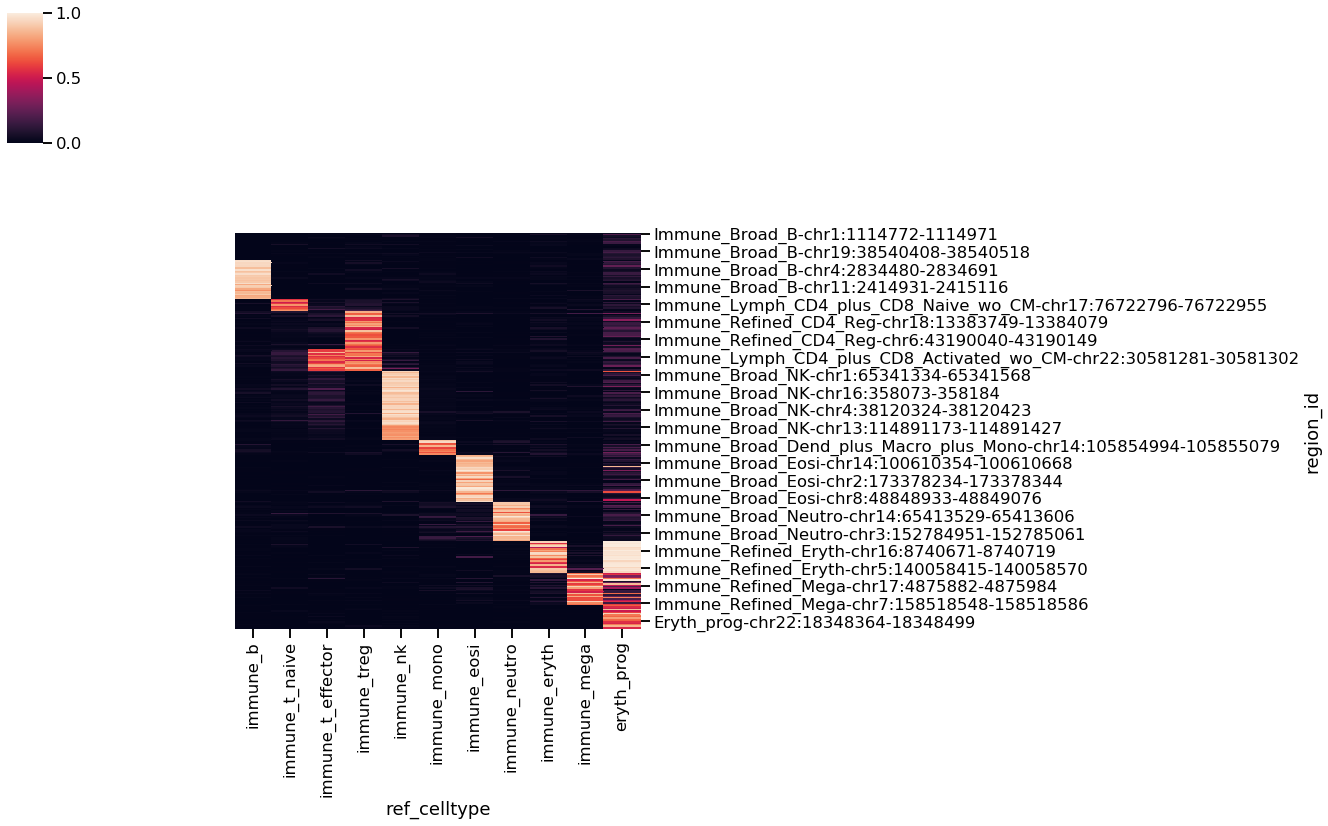

In [426]:
sns.clustermap(atlas, row_cluster=False, col_cluster=False)

In [427]:
# atlas=(atlas-atlas.mean())

In [428]:
atlas.mean() 

ref_celltype
immune_b             0.098469
immune_t_naive       0.035954
immune_t_effector    0.059150
immune_treg          0.113366
immune_nk            0.167060
immune_mono          0.040672
immune_eosi          0.118356
immune_neutro        0.091777
immune_eryth         0.076121
immune_mega          0.069214
eryth_prog           0.231112
dtype: float64

In [429]:
atlas.std()

ref_celltype
immune_b             0.267248
immune_t_naive       0.113058
immune_t_effector    0.151212
immune_treg          0.249853
immune_nk            0.335488
immune_mono          0.140014
immune_eosi          0.284264
immune_neutro        0.251875
immune_eryth         0.203751
immune_mega          0.201347
eryth_prog           0.293472
dtype: float64

In [430]:
atlas.mean() / atlas.std()

ref_celltype
immune_b             0.368453
immune_t_naive       0.318015
immune_t_effector    0.391173
immune_treg          0.453729
immune_nk            0.497963
immune_mono          0.290482
immune_eosi          0.416361
immune_neutro        0.364375
immune_eryth         0.373600
immune_mega          0.343758
eryth_prog           0.787509
dtype: float64

In [431]:
%%time

deconvolution_nnls = dcnv.compute_deconvolution_from_methyl_score_dir_nnls(path_to_methyl_score_dir=SCORE_DIR, 
                                                                          score_type=SCORE_VAR, 
                                                                          atlas=atlas, 
                                                                          match=False)

deconvolution_naive = dcnv.compute_deconvolution_from_methyl_score_dir_naive(path_to_methyl_score_dir=SCORE_DIR, 
                                                                             filter_cov=FILTER_COV, 
                                                                             score_var=SCORE_VAR, 
                                                                             ref_region_df=ref_region_df)


CPU times: user 4.67 s, sys: 36.6 ms, total: 4.71 s
Wall time: 4.71 s


In [432]:
deconvolution_nnls[12]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
ref_celltype,,,,,,,,,,,,,,,,,,,,
immune_b,0.057697,0.059542,0.058138,0.060633,0.057683,0.057767,0.056706,0.057990,0.059464,0.057879,0.059794,0.056321,0.057667,0.058754,0.057356,0.057218,0.056134,0.057920,0.058497,0.058575
immune_t_naive,0.168952,0.167140,0.168645,0.167519,0.166654,0.172075,0.167570,0.164007,0.169362,0.169606,0.168163,0.164099,0.163029,0.171258,0.167894,0.165131,0.163947,0.164985,0.168587,0.167187
immune_t_effector,0.042544,0.048492,0.044219,0.040968,0.044218,0.044777,0.044906,0.043368,0.043856,0.045008,0.041577,0.045845,0.046095,0.041318,0.043538,0.047859,0.045963,0.040382,0.043418,0.040157
immune_treg,0.000020,0.000000,0.000000,0.000993,0.000000,0.000610,0.000000,0.000142,0.000249,0.000013,0.000000,0.000058,0.000000,0.000000,0.001016,0.000159,0.000376,0.000455,0.000000,0.000721
immune_nk,0.047515,0.047392,0.048749,0.049684,0.048829,0.049005,0.047523,0.047972,0.047401,0.048254,0.047939,0.048203,0.048356,0.048427,0.048264,0.048087,0.048331,0.047976,0.048092,0.047038
immune_mono,0.099158,0.104129,0.093775,0.102814,0.100796,0.096758,0.094947,0.097670,0.102960,0.096418,0.100589,0.100658,0.101145,0.098520,0.100088,0.099440,0.097380,0.101063,0.098731,0.098227
immune_eosi,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
immune_neutro,0.558758,0.557246,0.558027,0.556701,0.559284,0.557549,0.557576,0.556323,0.559284,0.559339,0.558346,0.558345,0.560937,0.558973,0.558478,0.558390,0.560250,0.556651,0.556217,0.557516
immune_eryth,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [433]:
importlib.reload(cm)
importlib.reload(sm)
importlib.reload(dcnv)
importlib.reload(hlpr)

<module 'helper' from '/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/scripts/helper.py'>

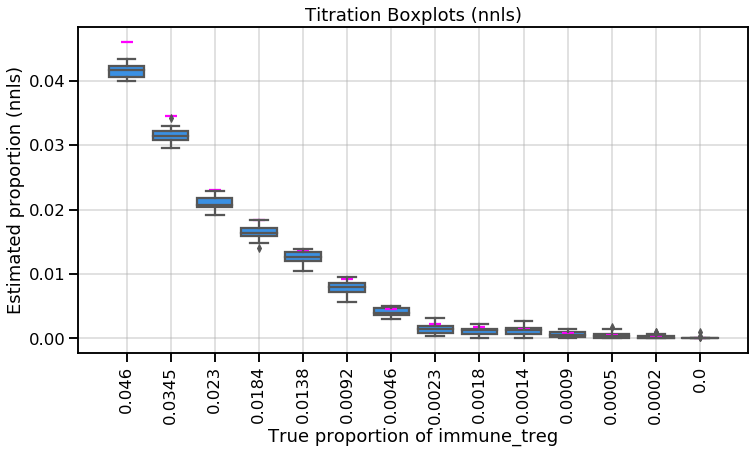

In [434]:
dcnv.boxplot_titration(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=[round(x, 4) for x in treg_titrating_proprotions],
                      deconvolution_method_name='nnls'
                      )

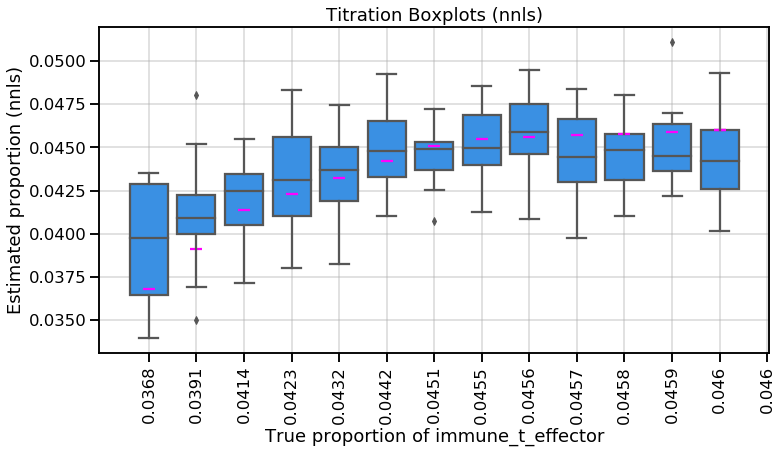

In [435]:
dcnv.boxplot_titration(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type='immune_t_effector',
                      true_proportions=[round(x, 4) for x in teff_titrating_proprotions],
                      deconvolution_method_name='nnls'
                      )

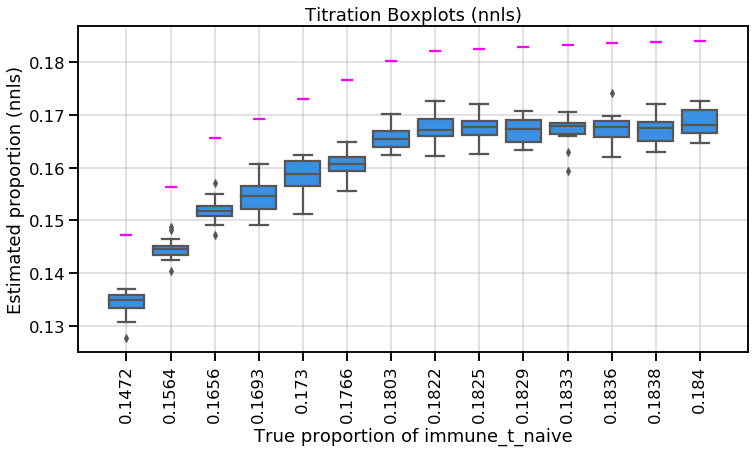

In [436]:
dcnv.boxplot_titration(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type='immune_t_naive',
                      true_proportions=[round(x, 4) for x in tnai_titrating_proprotions],
                      deconvolution_method_name='nnls'
                      )

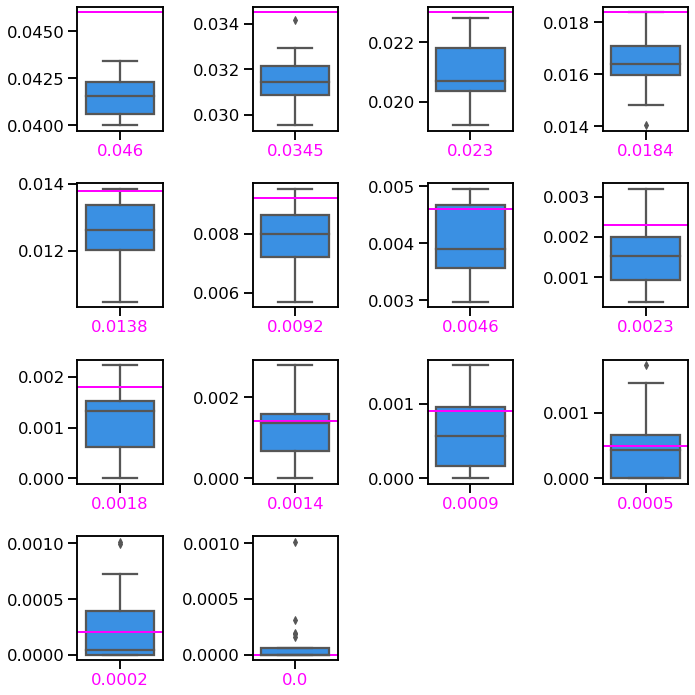

In [437]:
dcnv.boxplot_titration_zoom(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=[round(x, 4) for x in treg_titrating_proprotions],
                      deconvolution_method_name='nnls')

In [438]:
# spot check one mixture replicate

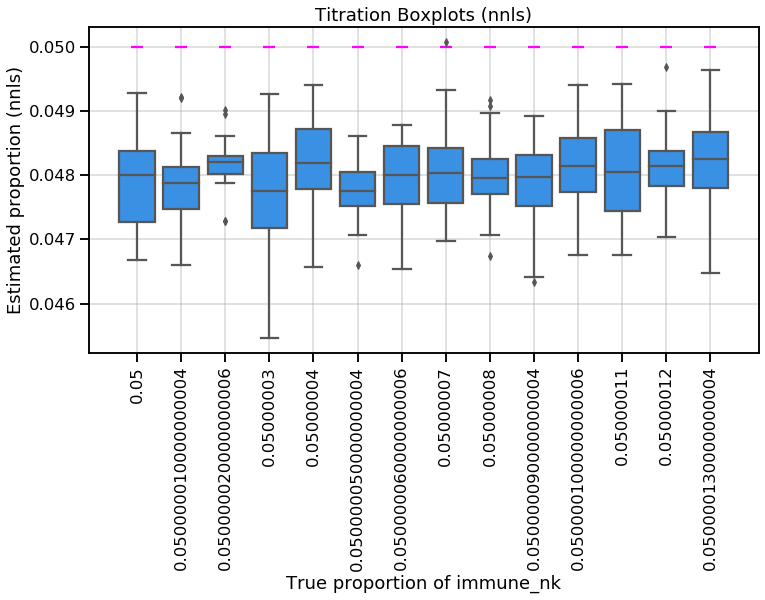

In [439]:
dcnv.boxplot_titration(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type='immune_nk',
                      true_proportions=list(np.repeat(0.05, len(tnai_titrating_proprotions)) + np.arange(14)*0.00000001),
                      deconvolution_method_name='nnls'
                      )

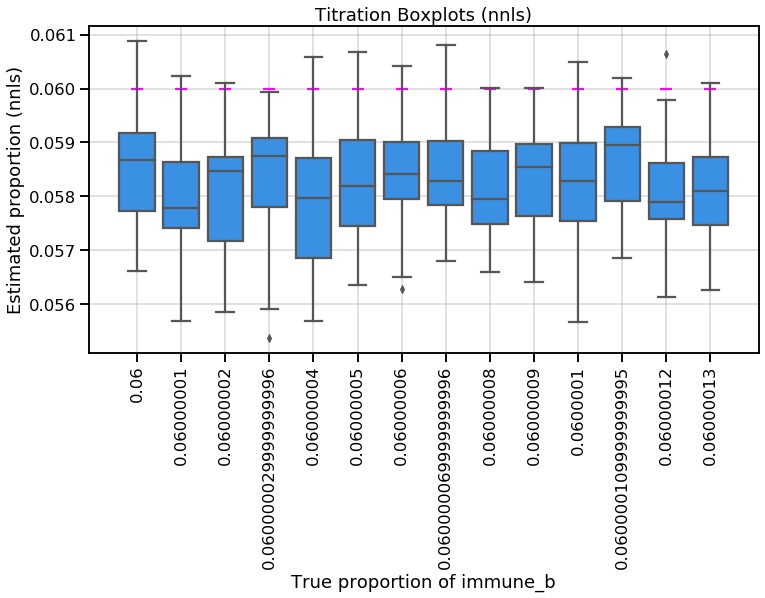

In [440]:
dcnv.boxplot_titration(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type='immune_b',
                      true_proportions=list(np.repeat(0.06, len(tnai_titrating_proprotions)) + np.arange(14)*0.00000001),
                      deconvolution_method_name='nnls'
                      )

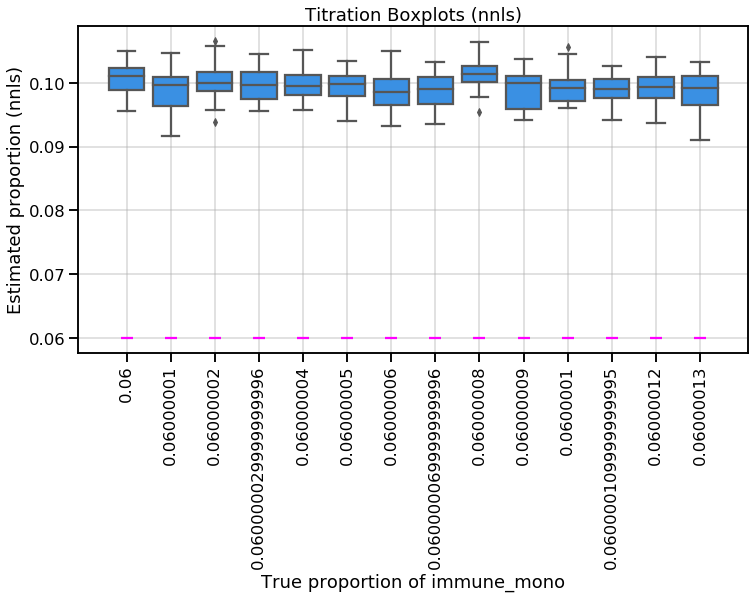

In [441]:
dcnv.boxplot_titration(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type='immune_mono',
                      true_proportions=list(np.repeat(0.06, len(tnai_titrating_proprotions)) + np.arange(14)*0.00000001),
                      deconvolution_method_name='nnls'
                      )

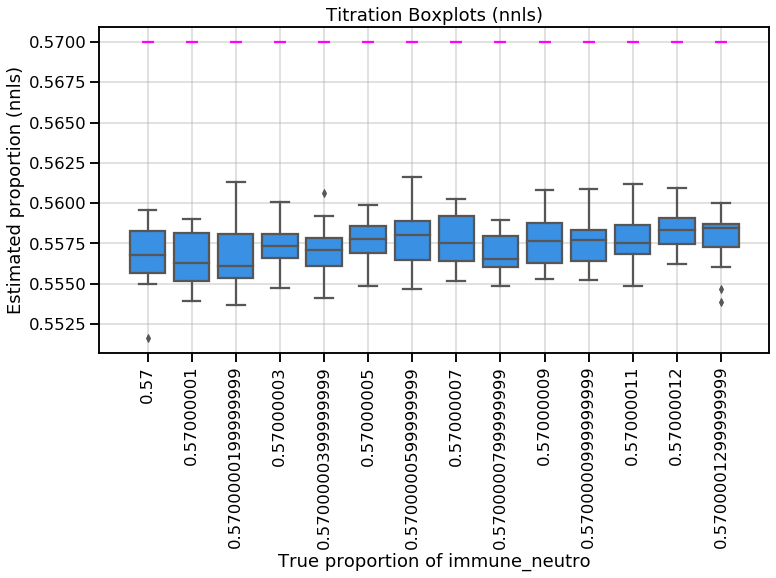

In [442]:
dcnv.boxplot_titration(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type='immune_neutro',
                      true_proportions=list(np.repeat(0.57, len(tnai_titrating_proprotions)) + np.arange(14)*0.00000001),
                      deconvolution_method_name='nnls'
                      )